In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime as dt
from sklearn.linear_model import LogisticRegression
from dreamclinic_churn_functions import *
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn_pandas import DataFrameMapper, FunctionTransformer
from sklearn.pipeline import Pipeline


# Dreamclinic Client Churn

I, Dale Kellegrew, used the past 3 years of Dreamclinic Massage INC client data in HIPPA compliance in order to model client churn. Modeling client churn is useful in order to provide data driven decisions to my CEO, Larisa Goldin.

## Loads data from pickle

In [2]:
client_df = pd.read_pickle('client_df.pkl')

## Cleans df columns

Removes NA values, strips and lowercases all therapist names, drops unnessesary columns which hold no infomation.

In [3]:
clean_client_df = clean_df(client_df)

/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Service_Category'] = df['Service_Category'].fillna(value='Massage')
/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Therapist'] = df['Therapist'].str.strip()
/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py

## Make a pipeline

In [4]:
mapper = DataFrameMapper([
    (['Therapist'], OneHotEncoder(categories="auto", drop='first')),
    (['Address_Zip'], OneHotEncoder(categories="auto", drop='first')),
    (['Service_Category'], OneHotEncoder(categories="auto", drop='first')),
    (['clientID'], None),
#     (['TransactionDate'], None),
    (['HrsWorked'], None)
    
], df_out=True)

mapper.fit(clean_client_df)
map_output = mapper.transform(clean_client_df)
map_output['Date'] = clean_client_df['TransactionDate'] 
map_output['Therapist'] = clean_client_df['Therapist']


## Groups by time

Creates a groupby object on months to so some exploratory data analysis.

In [5]:
g = groupby_time(clean_client_df, offset_alias='M')

## Aggregates and further cleans the Data 

unique_client_agg function groups by unique clientID to count how many of each feature each client has.

clean_agg_df further cleans the data and renames columns to accurately 
represent what they do.

In [6]:
client_count_df = unique_client_agg(g)
client_count_df = clean_agg_df(client_count_df)

# EDA
## Graph of unique client counts per month from August, 2016

It looks as though Dreamclinic was growing from August 2016 to around March 2018. In Febuary of 2019 there was a snowstorm that shut down Seattle and no one went to work for around a week which explains the dip.

I only had 4 days of data for the August 2019 and full months of data for the rest of the months. Which is why the graph sharply declines at the end.

A unique client is counting each individual person only once per month. Example: If someone comes in 3 times in 1 month they would only be counted as once on the graph.

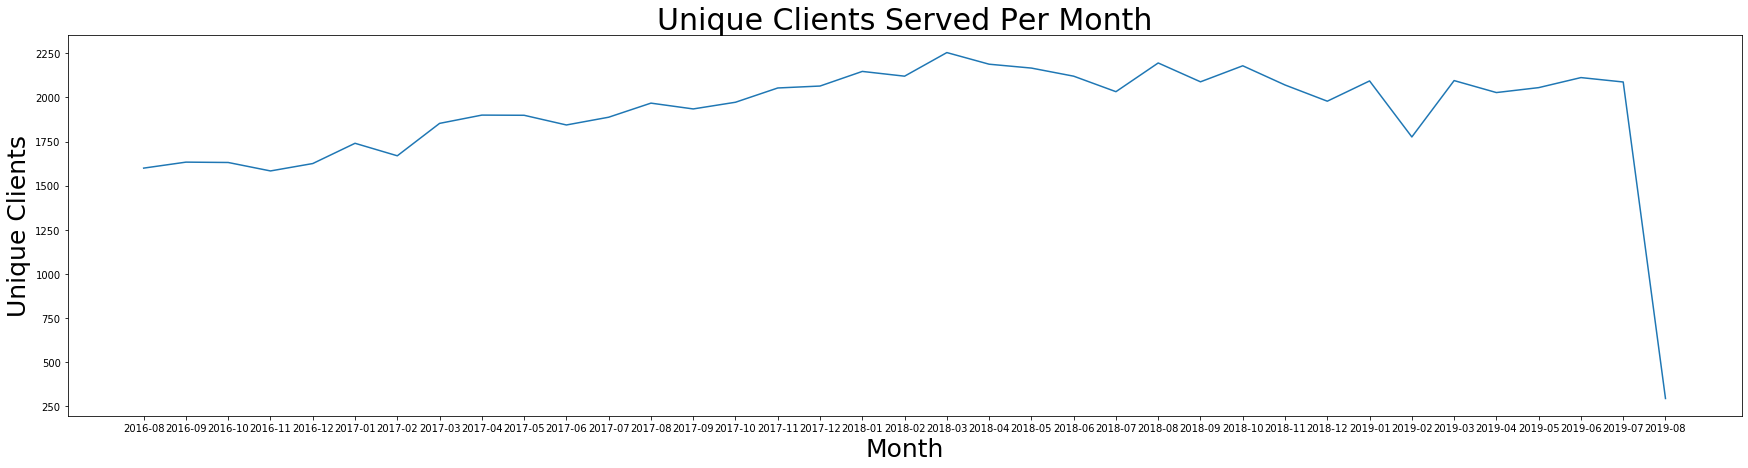

In [7]:
line_plot(df=client_count_df, 
          title='Unique Clients Served Per Month',
          x_label='Month',
          y_label='Unique Clients',
          x_column='month',
          y_column='client_count')

I also looked at unique zipcodes served and this hinted at a positive growth rate in the math 4 months where the unique client served per month looks like Dreamclinic has stopped growing.

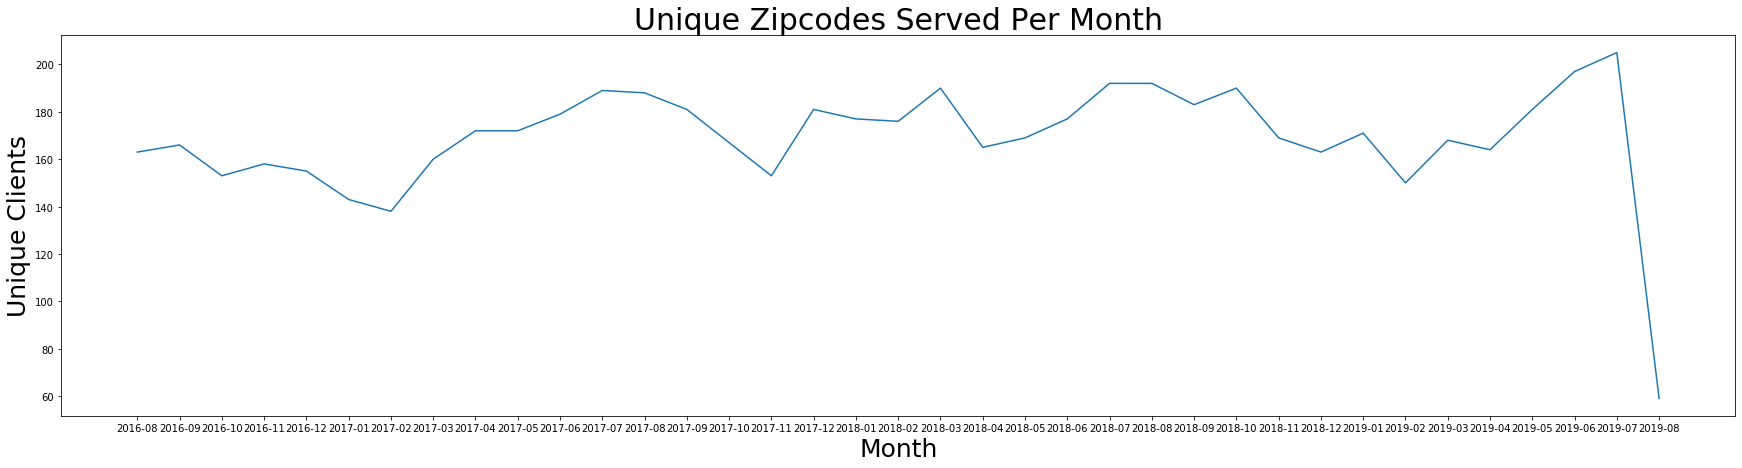

In [8]:
line_plot(df=client_count_df, 
          title='Unique Zipcodes Served Per Month', 
          x_label='Month', 
          y_label='Unique Clients',
          x_column='month',
          y_column='Address_Zip')

I wanted to see how many massages Dreamclinic gave per month regardless of if people came more than once per month so I counted all the massages given each month. The graph turned out very similar to the unique clients per month graph.

In [9]:
service_given_df = sum_client_agg(g)
service_given_df = clean_agg_df(service_given_df)

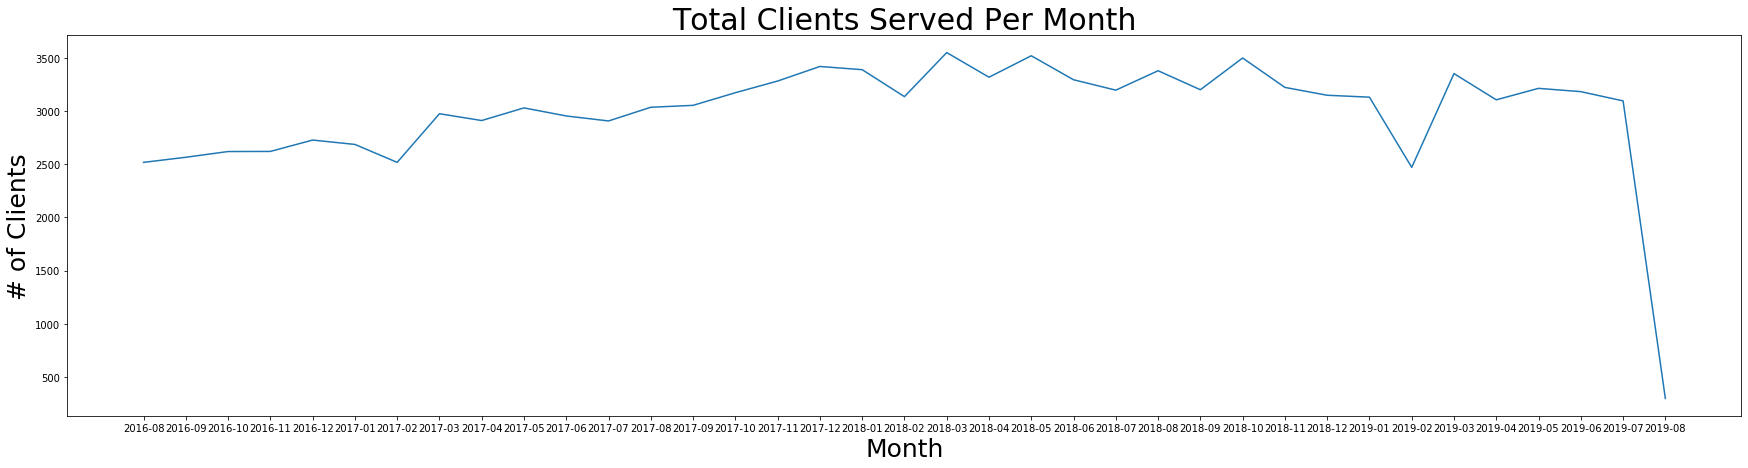

In [10]:
line_plot(df=service_given_df, 
          title='Total Clients Served Per Month', 
          x_label='Month', 
          y_label='# of Clients',
          x_column='month',
          y_column='Service_Category')

I wanted to know how many session(s) Dreamclinic's clients recieved in order to know who to target with what advertising in the future.

It looks like if Dreamclinic can target people who only come once and make them some of them come back a second time Dreamclinic could make a lot of money since people who come once make up 50% of all clients!


In [11]:
session_count_df, session_count_obj = session_count(client_df)

<function matplotlib.pyplot.show(*args, **kw)>

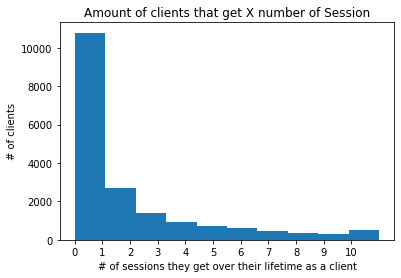

In [12]:
session_count_graph(session_count=session_count_obj, min_sessions=0, max_sessions=10)

In [27]:
session_count_obj

clientID
1001.0     171
1030.0       3
1065.0       1
1073.0       5
1075.0       8
          ... 
83454.0      1
83455.0      1
83457.0      1
83458.0      1
83461.0      1
Name: TransactionDate, Length: 21455, dtype: int64

## The average client get 5.5 sessions and sees 2.5 different therapists.
## People tend to get 1.25 hour sessions which is almost split between the 1h and 1.5h offerings we have.

In [13]:
client_df.groupby('clientID').nunique().mean()

TransactionDate     5.462503
clientID            1.000000
Therapist           2.605174
Address_City        0.907621
Address_State       0.907481
Address_Zip         0.898439
Invoice_Category    1.119506
Service_Category    0.887579
HrsWorked           1.375670
dtype: float64

# Mark Clients with Churned or Not Churned for futher modeling.

## Explain WHy im doing this for people to understand so that thye can use it themselves for their probelms also.

In [14]:
churn_df = temporal_split(df=map_output)

/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_churn_df['churn'] = False


## Temporally train/test split data for modeling.

In [15]:
test_df = temporal_split_test(churn_df)

In [16]:
train_df = temporal_split_train(churn_df)

## Aggregate our train and test splits.

In [17]:
train_agg_df = aggregate(train_df)
test_agg_df = aggregate(test_df)

## Turns address and churn columns into booleans.

In [18]:
address_columns= [col_name for col_name in train_agg_df.columns if col_name.startswith('Address_Zip_x0_')]
train_agg_df[address_columns] = train_agg_df[address_columns].astype(bool)
test_agg_df[address_columns] = test_agg_df[address_columns].astype(bool)
test_agg_df['churn'] = test_agg_df['churn'].astype(bool)
train_agg_df['churn'] = train_agg_df['churn'].astype(bool)

## Train/Test splits data

In [19]:
X_train = train_agg_df.drop('churn', axis=1)
y_train = train_agg_df['churn']
X_test =  test_agg_df.drop('churn', axis=1)
y_test = test_agg_df['churn']

## Scales our data for Logistic Regression Modeling

In [20]:
scale = StandardScaler()
scale.fit(X_train)
X_train_scaled = scale.transform(X_train)
X_test_scaled = scale.transform(X_test)

## Logistic Regression

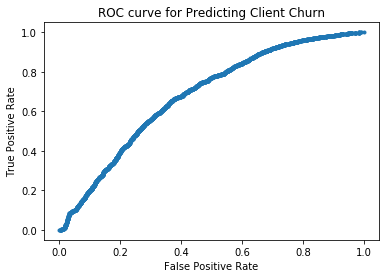

In [116]:
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_reg.score(X_test_scaled, y_test)
X_prob = log_reg.predict_proba(X_test_scaled)[:, -1]

roc_auc_score(y_test, X_prob)
fpr, tpr, thresholds = roc_curve(y_test, X_prob)

fpr, tpr, thresholds = roc_curve(y_test, X_prob)

plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Predicting Client Churn")
plt.show();

In [100]:
from sklearn.metrics import average_precision_score
y_score_log_reg = log_reg.decision_function(X_test_scaled)

average_precision = average_precision_score(y_test, y_score_log_reg)


print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

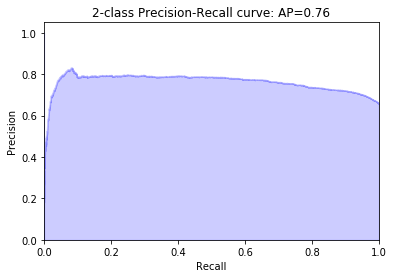

In [102]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score_log_reg)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Logistic Regression Confusion Matrix

In [113]:
predictions_df = pd.DataFrame(log_reg.predict_proba(X_test_scaled))
predictions_df['prediction'] = 0
predictions_df['prediction'] = (predictions_df[1] >= .8)
confusion_matrix(y_test, predictions_df['prediction'])
y_pred_log_reg = predictions_df['prediction']

Normalized confusion matrix


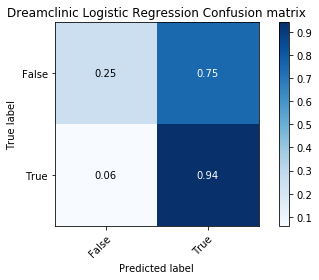

In [114]:
plot_confusion_matrix(y_test, 
                      y_pred_log_reg, 
                      [False, True],
                      normalize=True,
                      title='Dreamclinic Logistic Regression Confusion matrix',
                      cmap=plt.cm.Blues)

## Random Forest Classifier

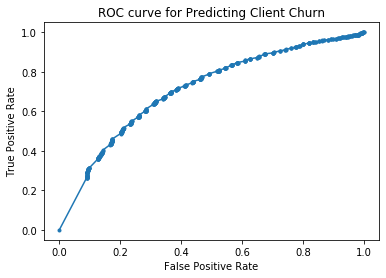

In [106]:
rand_for = RandomForestClassifier(n_estimators=100)
rand_for.fit(X_train, y_train)
rand_for.score(X_test, y_test)
rand_for_X_prob = rand_for.predict_proba(X_test)[:, -1]
roc_auc_score(y_test, rand_for_X_prob)
fpr, tpr, thresholds = roc_curve(y_test, rand_for_X_prob)

plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Predicting Client Churn")
plt.show();

## Confusion Matrix

### Random Forest

In [111]:
predictions_df = pd.DataFrame(rand_for.predict_proba(X_test))
predictions_df['prediction'] = 0
predictions_df['prediction'] = (predictions_df[1] >= .7)
cm = confusion_matrix(y_test, predictions_df['prediction'])
y_pred_rand_for = predictions_df['prediction']

Normalized confusion matrix


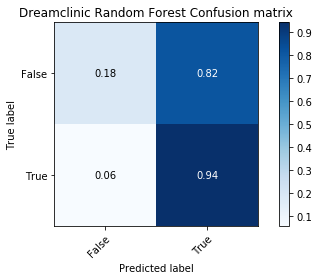

In [112]:
plot_confusion_matrix(y_test, 
                      y_pred_rand_for, 
                      [False, True],
                      normalize=True,
                      title='Dreamclinic Random Forest Confusion matrix',
                      cmap=plt.cm.Blues);